In [1]:
%load_ext autoreload
%autoreload 2
import torch
import pickle
import sys
import os
import glob
sys.path.append('../../data_processing')
sys.path.append('../../model')
import CNN
import TF_data_loader_gcPBM_bubble_linear
import TF_data_loader_gcPBM_seq_only
from torch.utils import data as D
import torch.cuda as cuda
import numpy as np
import scipy.stats as stats
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from sklearn.metrics import mean_squared_error, r2_score
from IPython.display import Image
import random

In [2]:
def generate_structure(features, pool, kernel, filters, layers):
    structure = {}
    for feature in features:
        structure[feature] = {}
        for poolnum in pool:
            structure[feature][poolnum] = {}
            for kernum in kernel:
                structure[feature][poolnum][kernum] = {}
                for filt in filters:
                    structure[feature][poolnum][kernum][filt] = {}
                    for layer in layers:
                        structure[feature][poolnum][kernum][filt][layer] = []
    return structure

In [3]:
model_paths = glob.glob('../../../trained_model/gcPBM/**/**/**/**/**/*', recursive=False)
model_paths = [m for m in model_paths if m.split('/')[-1] == 'max' or 'mad' or 'myc']
model_paths = [m for m in model_paths if m.split('/')[-2] == '1']
model_paths = [m for m in model_paths if m.split('/')[-3] == '6' or '8' or '10']
model_paths = [m for m in model_paths if m.split('/')[-4] == '64']
model_paths = [m for m in model_paths if m.split('/')[-5] == '3']
model_paths = [m for m in model_paths if m.split('/')[-6] == 'bubble_linear' or 'seq_only']
features = []
pool = []
kernel = []
filters = []
layers = []
tfs = []

for model_path in model_paths:
    # parse the model path to get the TF, layers, filters, kernel, and pool
    feature = model_path.split('/')[-6]
    if feature not in features:
        features.append(str(feature))
    layer = model_path.split('/')[-5]
    if layer not in layers:
        layers.append(str(layer))
    filt = model_path.split('/')[-4]
    if filt not in filters:
        filters.append(str(filt))
    kern = model_path.split('/')[-3]
    if kern not in kernel:
        kernel.append(str(kern))
    p = model_path.split('/')[-2]
    if p not in pool:
        pool.append(str(p))
    tf = model_path.split('/')[-1]
    if tf not in tfs:
        tfs.append(str(tf))

In [4]:
kernel

['7', '6', '10', '8', '5', '9']

In [5]:
def create_true_pred(TF):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_paths = glob.glob('../../../trained_model/gcPBM/**/**/**/**/**/*', recursive=False)
    model_paths = [m for m in model_paths if m.split('/')[-6] == 'bubble_linear' or 'seq_only']
    model_paths = [m for m in model_paths if m.split('/')[-5] == '3']
    model_paths = [m for m in model_paths if m.split('/')[-4] == '64']
    model_paths = [m for m in model_paths if m.split('/')[-3] == '6' or '8' or '10']
    model_paths = [m for m in model_paths if m.split('/')[-2] == '1']
    model_paths = [m for m in model_paths if m.split('/')[-1] == TF]
    test_set_path = f'../../../data/gcPBM_data/{TF}.pkl'
    # seq only
    seq_only_test_set = TF_data_loader_gcPBM_seq_only.TF_data(data_path=test_set_path, partition='test')
    seq_only_test_loader = D.DataLoader(seq_only_test_set, batch_size=1, num_workers=20)
    # seq and bubble
    seq_bubble_test_set = TF_data_loader_gcPBM_bubble_linear.TF_data(data_path=test_set_path, partition='test')
    seq_bubble_test_loader = D.DataLoader(seq_bubble_test_set, batch_size=1, num_workers=20)
    
    features = []
    pool = []
    kernel = []
    filters = []
    layers = []

    for model_path in model_paths:
        # parse the model path to get the TF, layers, filters, kernel, and pool
        feature = model_path.split('/')[-6]
        if feature not in features:
            features.append(str(feature))
        layer = model_path.split('/')[-5]
        if layer not in layers:
            layers.append(str(layer))
        filt = model_path.split('/')[-4]
        if filt not in filters:
            filters.append(str(filt))
        kern = model_path.split('/')[-3]
        if kern not in kernel:
            kernel.append(str(kern))
        p = model_path.split('/')[-2]
        if p not in pool:
            pool.append(str(p))

    y_true = generate_structure(features, pool, kernel, filters, layers)
    y_pred = generate_structure(features, pool, kernel, filters, layers)

    for model_path in tqdm(model_paths, desc='Model', unit='model', leave=True):
        # parse the model path to get the TF, layers, filters, kernel, and pool
        features = model_path.split('/')[-6]
        layers = model_path.split('/')[-5]
        filters = model_path.split('/')[-4]
        kernel = model_path.split('/')[-3]
        pool = model_path.split('/')[-2]

        check_point = torch.load(model_path, map_location=device)

        if features == 'seq_only':
            test_loader = seq_only_test_loader
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=4)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device).eval()

            # Iterate over the test set and get the true and predicted labels
            for seq, label in tqdm(test_loader, desc='Test', unit='batch', leave=False):
                seq = seq.to(device).requires_grad_()
                out = model(seq)

                # Convert tensors to NumPy arrays
                label_arr = label.cpu().numpy()
                out_arr = out.detach().cpu().numpy()

                # Append the true and predicted labels to the respective lists
                y_true[features][pool][kernel][filters][layers].extend(label_arr)
                y_pred[features][pool][kernel][filters][layers].extend(out_arr)

        elif features == 'bubble_linear':
            test_loader = seq_bubble_test_loader
            model = CNN.CNN(kernel=int(kernel), pool=int(pool), filters=int(filters), layers=int(layers), input_channels=5)
            model.load_state_dict(check_point['state_dict'])
            model = model.to(device).eval()

            # Iterate over the test set and get the true and predicted labels
            for seq, feat, label in tqdm(test_loader, desc='Test', unit='batch', leave=False):
                seq_feat = torch.cat([seq, feat.unsqueeze(0)], dim=1).to(device)
                out = model(seq_feat)

                # Convert tensors to NumPy arrays
                label_arr = label.cpu().numpy()
                out_arr = out.detach().cpu().numpy()
                
                # Append the true and predicted labels to the respective lists
                y_true[features][pool][kernel][filters][layers].extend(label_arr)
                y_pred[features][pool][kernel][filters][layers].extend(out_arr)
                
    return y_true, y_pred

In [6]:
# Calculate accuracy for each model
def accuracy_checker(top_number, TF):
    mses = {}
    r2s = {}

    for features, feature_dict in results[f'{TF}_pred'].items():
        for pool, pool_dict in feature_dict.items():
            for kernel, kernel_dict in pool_dict.items():
                for filters, filters_dict in kernel_dict.items():
                    for layers, pred_values in filters_dict.items():
                        # Assuming true_values and pred_values are NumPy arrays

                        # Calculate accuracy
                        mse = mean_squared_error(results[f'{TF}_true'][features][pool][kernel][filters][layers], pred_values)
                        r2 = r2_score(results[f'{TF}_true'][features][pool][kernel][filters][layers], pred_values)

                        # Create a model key
                        model_key = f"{features}_{pool}_{kernel}_{filters}_{layers}"

                        # Store the accuracy in the dictionary
                        mses[model_key] = mse
                        r2s[model_key] = r2

    # Sort the models based on accuracy in descending order
    sorted_mses = sorted(mses.items(), key=lambda x: x[1], reverse=False)
    sorted_r2s = sorted(r2s.items(), key=lambda x: x[1], reverse=True)

    # Print the models with the highest accuracy
    print(f'TF = {TF}')
    for model, accuracy in sorted_mses[:int(top_number)]:
        print(f"Model: {model}, MSE: {accuracy}")
    for model, accuracy in sorted_r2s[:int(top_number)]:
        print(f"Model: {model}, r2: {accuracy}")
            
    return sorted_mses[:int(top_number)], sorted_r2s[:int(top_number)]

In [7]:
def chart_maker(TF):
    figpath = []
    # Iterate over the hyperparameters and features
    for features, feature_dict in results[f'{TF}_true'].items():
        for pool, pool_dict in feature_dict.items():
            for kernel, kernel_dict in pool_dict.items():
                for filters, filters_dict in kernel_dict.items():
                    for layers, y_values in filters_dict.items():
                        # Get the corresponding predicted values
                        y_preds = results[f'{TF}_pred'][features][pool][kernel][filters][layers]

                        # Calculate MSE
                        mse = mean_squared_error(y_values, y_preds)

                        # Calculate R2
                        r2 = r2_score(y_values, y_preds)

                        # Determine the range for y-axis using min and max of y_preds
                        y_min = min(y_preds)
                        y_max = max(y_preds)

                        # Create a figure with a single subplot for the scatterplot
                        fig, ax = plt.subplots(figsize=(8, 8))

                        # Scatterplot with adjusted dot size
                        ax.scatter(y_values, y_preds, s=50, alpha=0.5)  # Adjust the size parameter (s) to set the dot size
                        
                        # Scatterplot
                        ax.scatter(y_values, y_preds, alpha=0.5)
                        ax.plot([min(y_values), max(y_values)], [y_min, y_max], color='red', linestyle='--')
                        ax.set_xlabel('True Labels')
                        ax.set_ylabel('Predicted Labels')
                        ax.set_title(f'Scatterplot - Features: {features}, Pool: {pool}, Kernel: {kernel}, Filters: {filters}, Layers: {layers}\n MSE: {mse:.4f}, R2: {r2:.4f}')
                        
                        # Save the figure in the current directory
                        fig_name = f'{features}_{pool}_{kernel}_{filters}_{layers}.png'
                        fig_path = f'figs/{fig_name}'
                        fig.savefig(fig_path)
                        figpath.extend(fig_path)
                        plt.show(fig)
                        plt.close(fig)

In [31]:
def chart_puller(TF):
    # Iterate over the hyperparameters and features
    for result in results[f'{TF}_mses']:
        model_path = result[0]
        components = model_path.split('_')
        layers = components.pop(-1)
        filters = components.pop(-1)
        kernel = components.pop(-1)
        pool = components.pop(-1)
        features = '_'.join(components)
        
        y_values = results[f'{TF}_true'][features][pool][kernel][filters][layers]
        # Get the corresponding predicted values
        y_preds = results[f'{TF}_pred'][features][pool][kernel][filters][layers]

        # Calculate MSE
        mse = mean_squared_error(y_values, y_preds)

        # Calculate R2
        r2 = r2_score(y_values, y_preds)

        # Determine the range for y-axis using min and max of y_preds
        y_min = min(y_preds)
        y_max = max(y_preds)

        # Create a figure with a single subplot for the scatterplot
        fig, ax = plt.subplots(figsize=(8, 8))

        # Scatterplot with adjusted dot size
        colors = np.random.uniform(0, 0.5, size=3)
        ax.scatter(y_values, y_preds, s=10, alpha=0.5, color=colors, marker='.')  # Adjust the size parameter (s) to set the dot size

        # Scatterplot
        ax.plot([min(y_values), max(y_values)], [y_min, y_max], color='red', linestyle='--')
        ax.set_xlabel('True Labels')
        ax.set_ylabel('Predicted Labels')
        ax.set_title(f'{TF} - Features: {features}, Pool: {pool}, Kernel: {kernel}, Filters: {filters}, Layers: {layers}\n MSE: {mse:.4f}, R2: {r2:.4f}')

        # Save the figure in the current directory
        fig_name = f'{TF}_{features}_{pool}_{kernel}_{filters}_{layers}.png'
        fig_path = f'figs/seq_only_bubble_linear/{fig_name}'
        fig.savefig(fig_path)
        plt.show(fig)
        plt.close(fig)

In [9]:
# Initialize a dictionary to store the true and predicted values
results = {}

# Iterate over the TF list
for TF in ['mad', 'max', 'myc']:
    # Call the create_true_pred function and assign the results to dynamically generated variable names
    true_values, pred_values = create_true_pred(TF)
    
    # Store the true and predicted values in the dictionary
    results[f'{TF}_true'] = true_values
    results[f'{TF}_pred'] = pred_values


Model:   0%|          | 0/10 [00:00<?, ?model/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Test:   0%|          | 0/1507 [00:00<?, ?batch/s]

Model:   0%|          | 0/10 [00:00<?, ?model/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Test:   0%|          | 0/1714 [00:00<?, ?batch/s]

Model:   0%|          | 0/10 [00:00<?, ?model/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

Test:   0%|          | 0/1386 [00:00<?, ?batch/s]

In [19]:
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['mad_true']['seq_only']['1']:
        del results['mad_true']['seq_only']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['mad_true']['bubble_linear']['1']:
        del results['mad_true']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['mad_pred']['bubble_linear']['1']:
        del results['mad_pred']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['mad_pred']['seq_only']['1']:
        del results['mad_pred']['seq_only']['1'][key]

In [33]:
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['max_true']['seq_only']['1']:
        del results['max_true']['seq_only']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['max_true']['bubble_linear']['1']:
        del results['max_true']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['max_pred']['bubble_linear']['1']:
        del results['max_pred']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['max_pred']['seq_only']['1']:
        del results['max_pred']['seq_only']['1'][key]

In [34]:
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['myc_true']['seq_only']['1']:
        del results['myc_true']['seq_only']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['myc_true']['bubble_linear']['1']:
        del results['myc_true']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['myc_pred']['bubble_linear']['1']:
        del results['myc_pred']['bubble_linear']['1'][key]
        
# Assuming 'results' is your dictionary
keys_to_delete = ['5', '9', '7']

for key in keys_to_delete:
    if key in results['myc_pred']['seq_only']['1']:
        del results['myc_pred']['seq_only']['1'][key]

In [26]:
# save results
with open('results_6_8_10.pkl', 'wb') as f:
    pickle.dump(results, f)

In [27]:
# load results
with open('results_6_8_10.pkl', 'rb') as f:
    results = pickle.load(f)

TF = mad
Model: seq_only_1_6_64_3, MSE: 0.025164015591144562
Model: seq_only_1_8_64_3, MSE: 0.02559092827141285
Model: bubble_linear_1_6_64_3, MSE: 0.025975389406085014
Model: seq_only_1_10_64_3, MSE: 0.025992512702941895
Model: bubble_linear_1_8_64_3, MSE: 0.02697504125535488
Model: bubble_linear_1_10_64_3, MSE: 0.02804403379559517
Model: seq_only_1_6_64_3, r2: 0.9751617209427638
Model: seq_only_1_8_64_3, r2: 0.9747403303054708
Model: bubble_linear_1_6_64_3, r2: 0.9743608481893277
Model: seq_only_1_10_64_3, r2: 0.9743439469430584
Model: bubble_linear_1_8_64_3, r2: 0.9733741378803168
Model: bubble_linear_1_10_64_3, r2: 0.9723189799559782


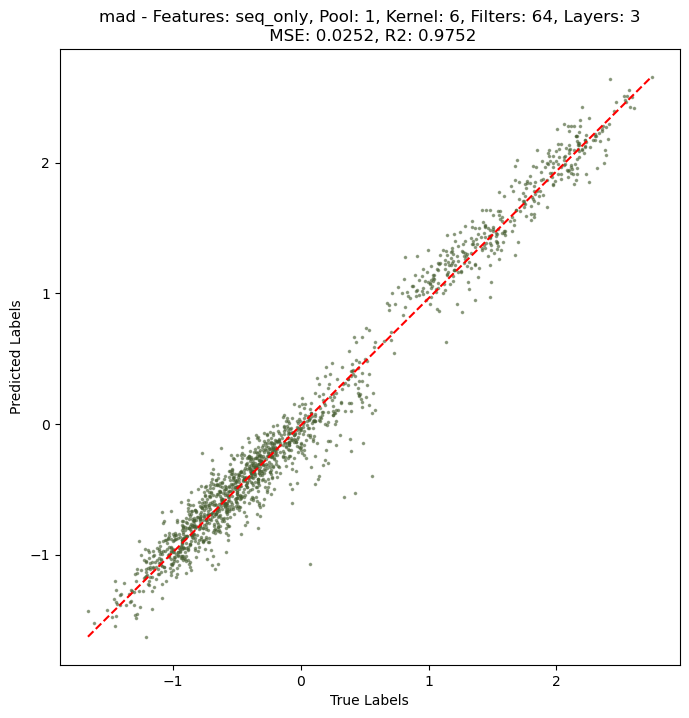

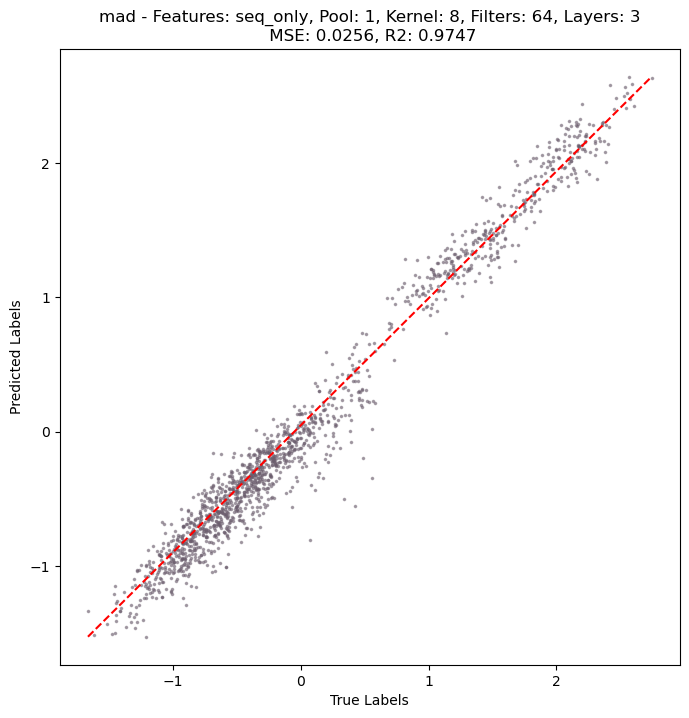

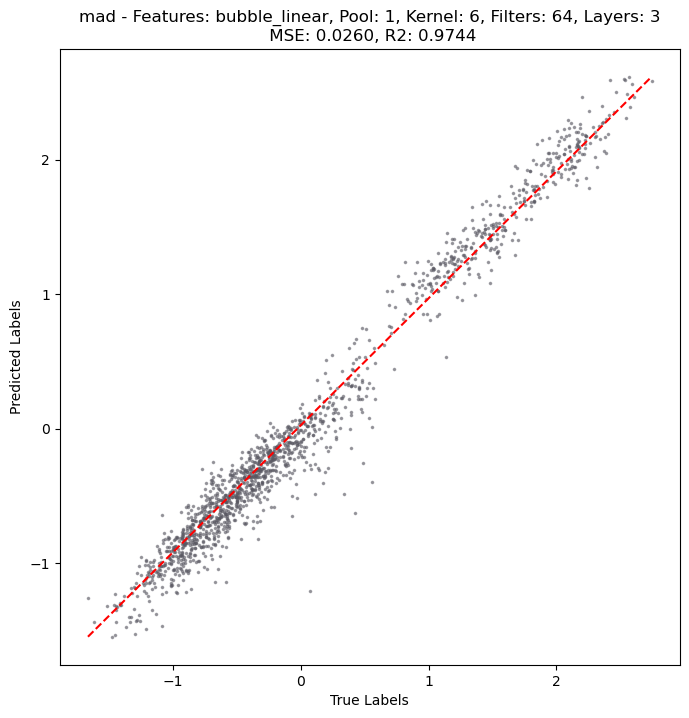

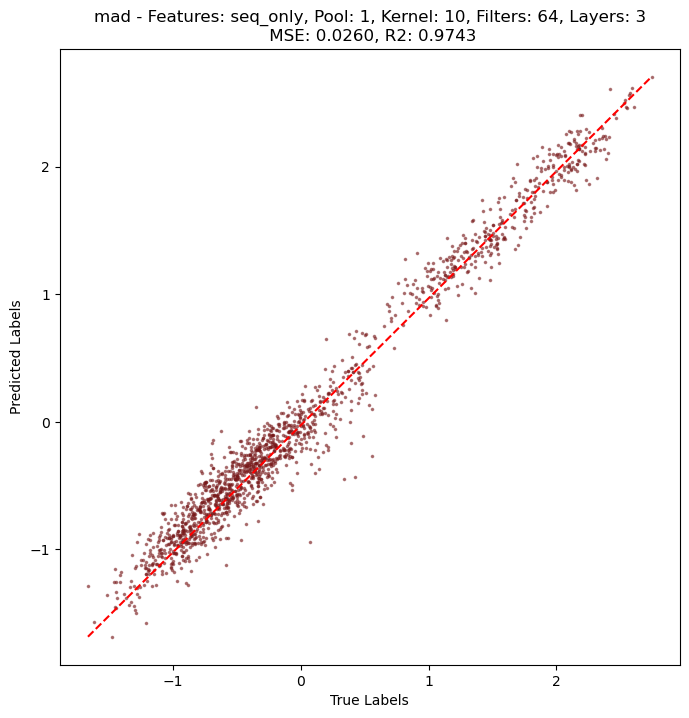

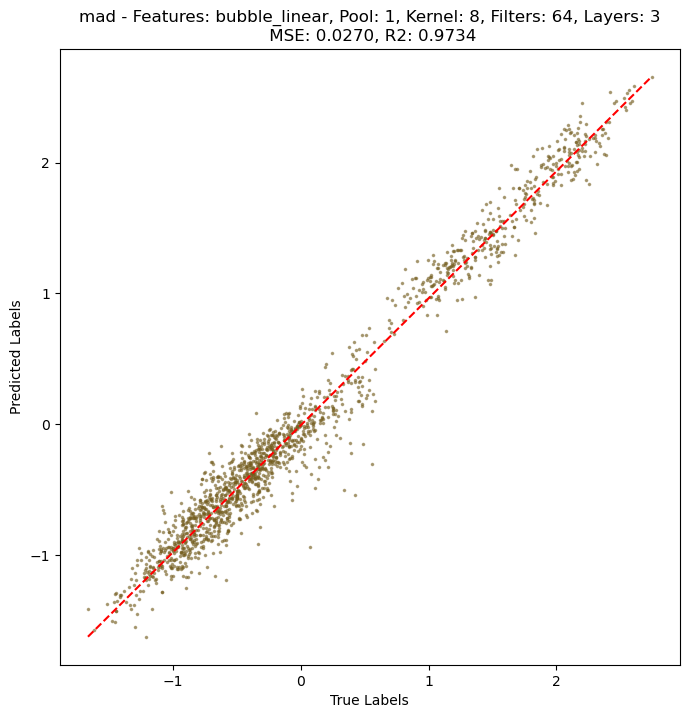

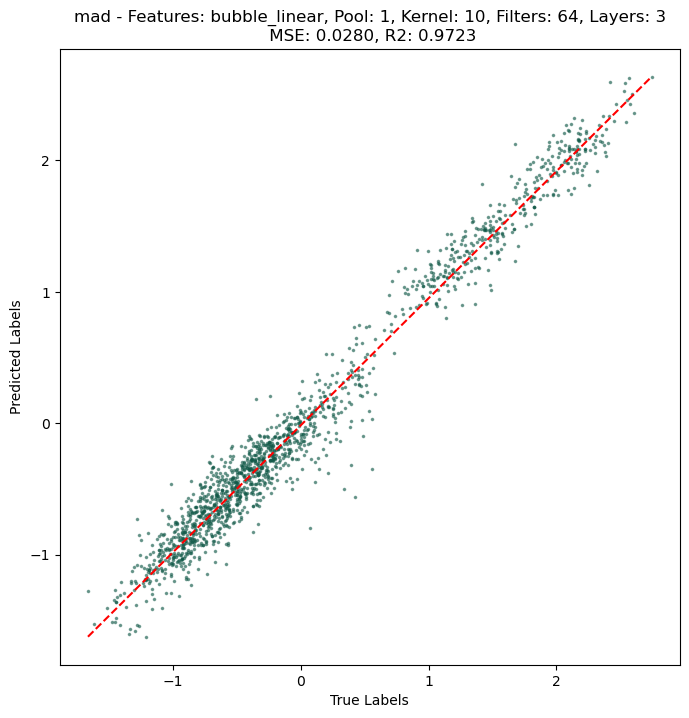

TF = max
Model: bubble_linear_1_6_64_3, MSE: 0.04008778929710388
Model: seq_only_1_6_64_3, MSE: 0.04050329700112343
Model: seq_only_1_8_64_3, MSE: 0.040858376771211624
Model: seq_only_1_10_64_3, MSE: 0.04170531406998634
Model: bubble_linear_1_8_64_3, MSE: 0.0423930287361145
Model: bubble_linear_1_10_64_3, MSE: 0.043693408370018005
Model: bubble_linear_1_6_64_3, r2: 0.960649553399618
Model: seq_only_1_6_64_3, r2: 0.9602416902661023
Model: seq_only_1_8_64_3, r2: 0.9598931401387409
Model: seq_only_1_10_64_3, r2: 0.9590617832927455
Model: bubble_linear_1_8_64_3, r2: 0.9583867144681565
Model: bubble_linear_1_10_64_3, r2: 0.9571102520169519


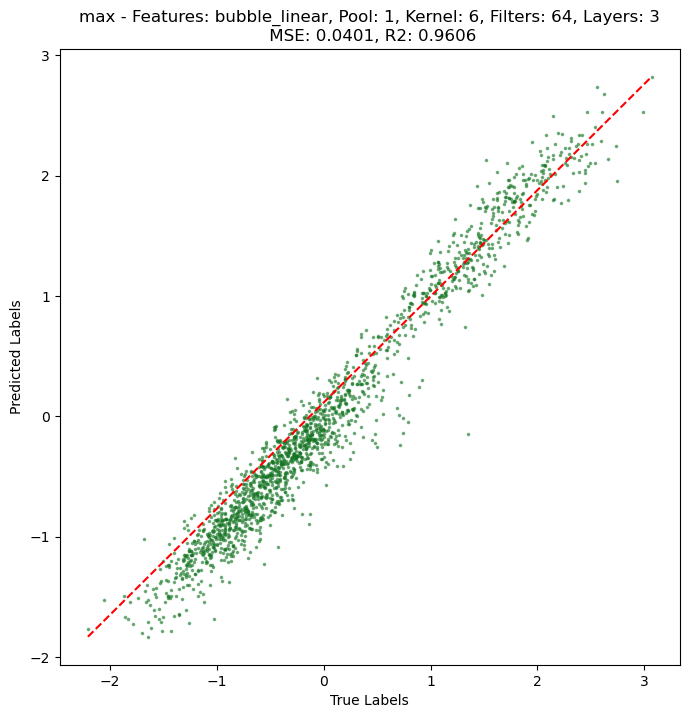

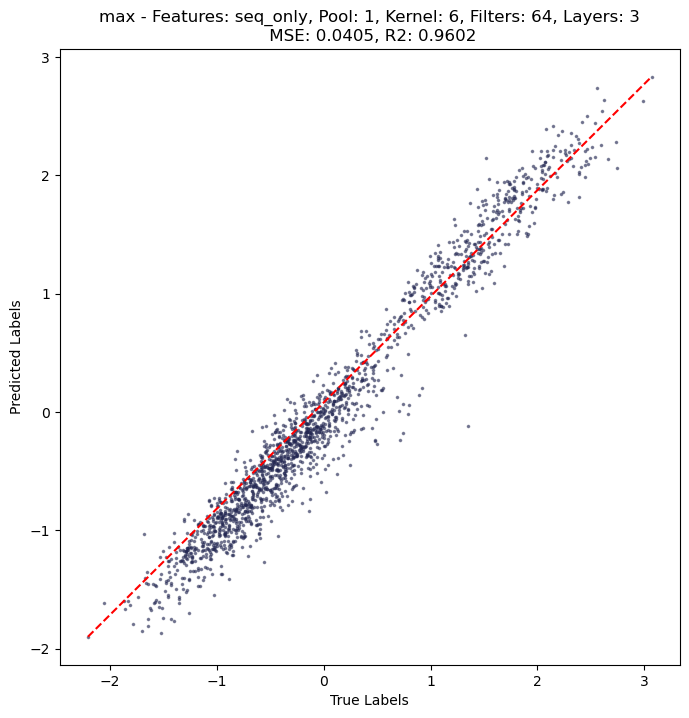

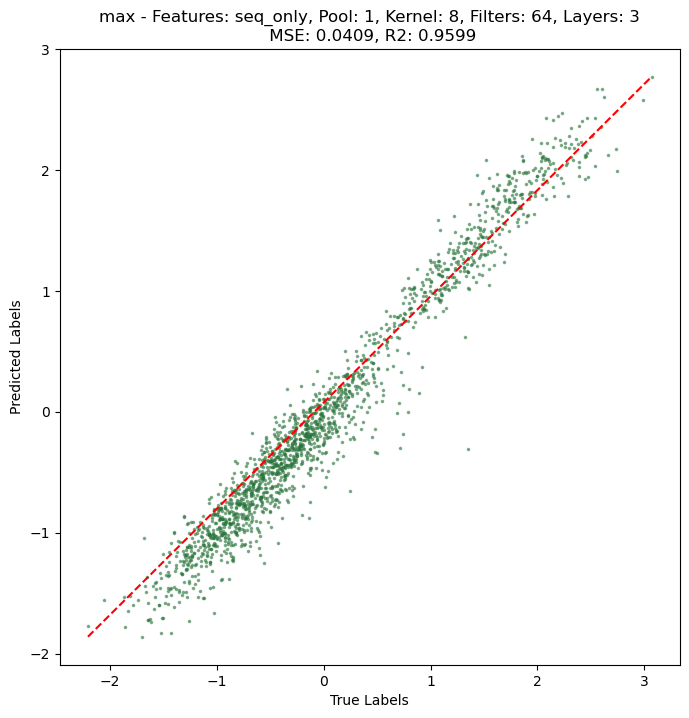

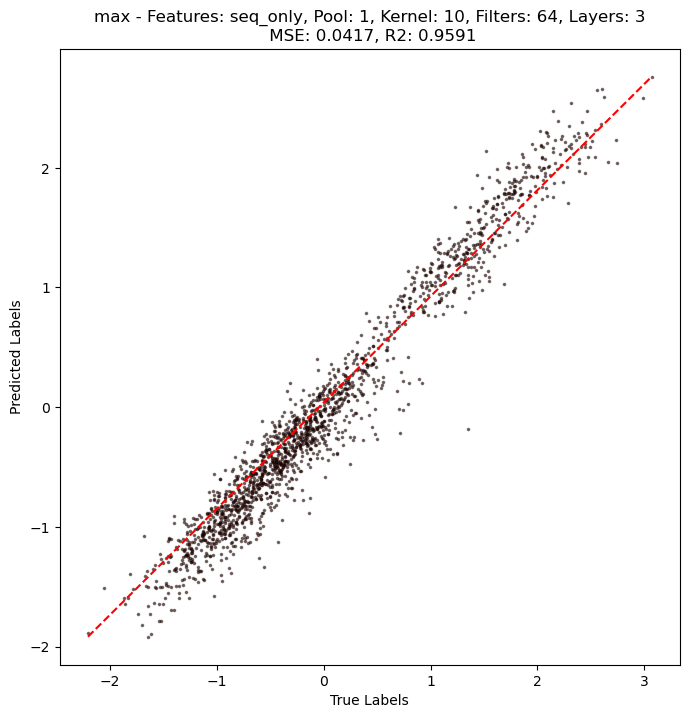

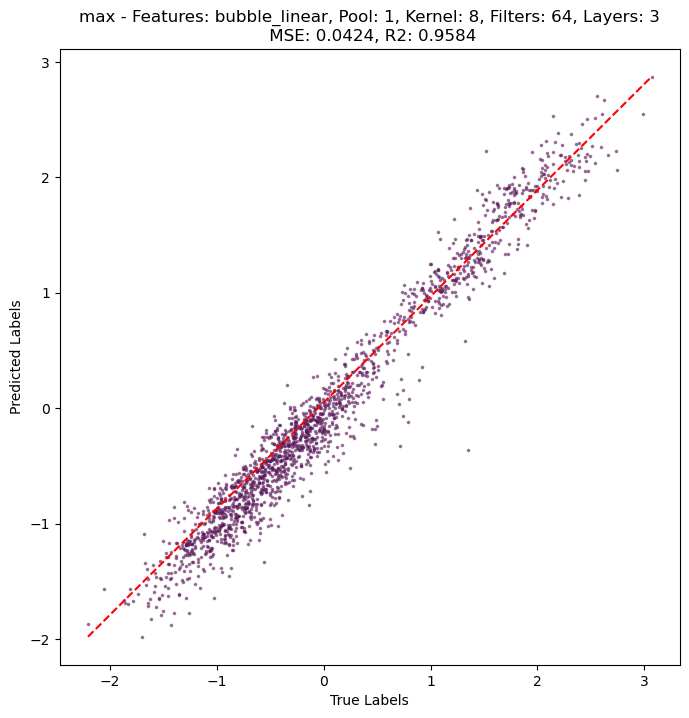

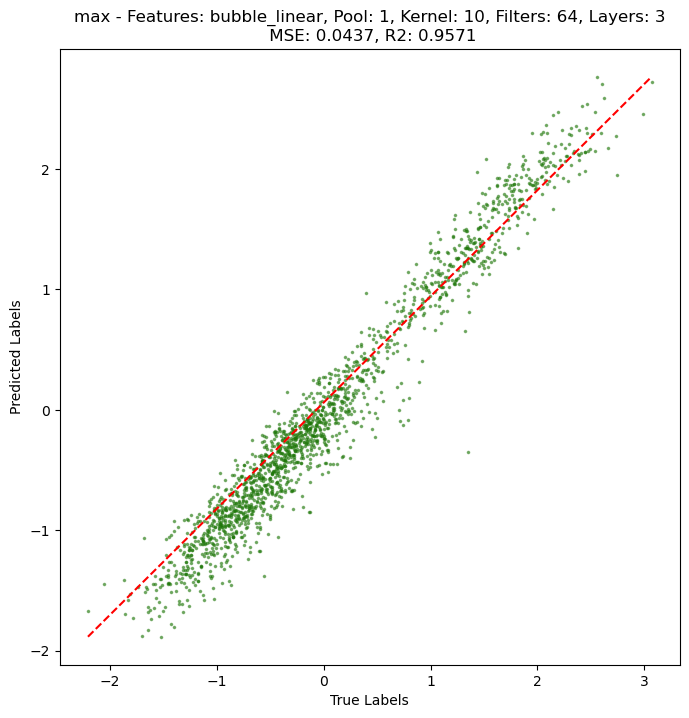

TF = myc
Model: seq_only_1_8_64_3, MSE: 0.05695045739412308
Model: seq_only_1_10_64_3, MSE: 0.05770198628306389
Model: bubble_linear_1_8_64_3, MSE: 0.05852825567126274
Model: seq_only_1_6_64_3, MSE: 0.060217346996068954
Model: bubble_linear_1_6_64_3, MSE: 0.060966987162828445
Model: bubble_linear_1_10_64_3, MSE: 0.06115123629570007
Model: seq_only_1_8_64_3, r2: 0.9444290673365138
Model: seq_only_1_10_64_3, r2: 0.9436957503397924
Model: bubble_linear_1_8_64_3, r2: 0.9428894908346188
Model: seq_only_1_6_64_3, r2: 0.9412413163392869
Model: bubble_linear_1_6_64_3, r2: 0.940509840597948
Model: bubble_linear_1_10_64_3, r2: 0.9403300450380424


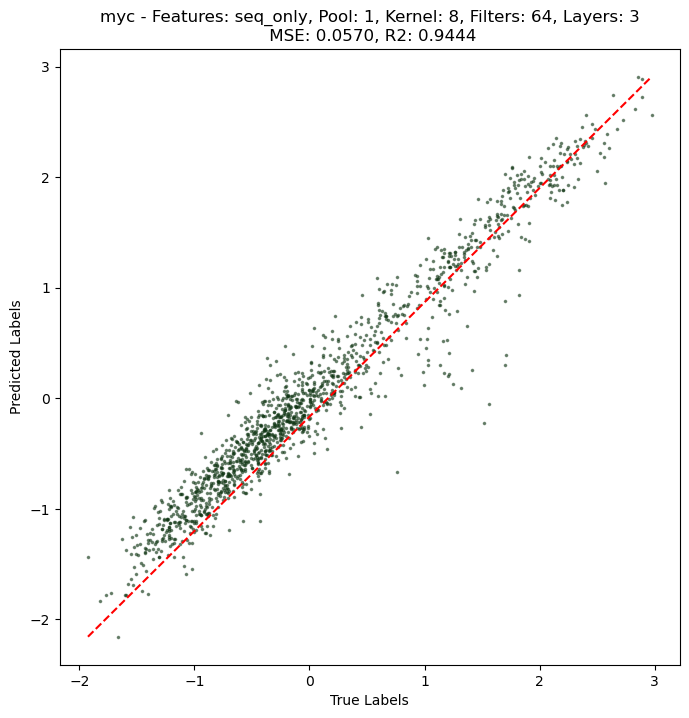

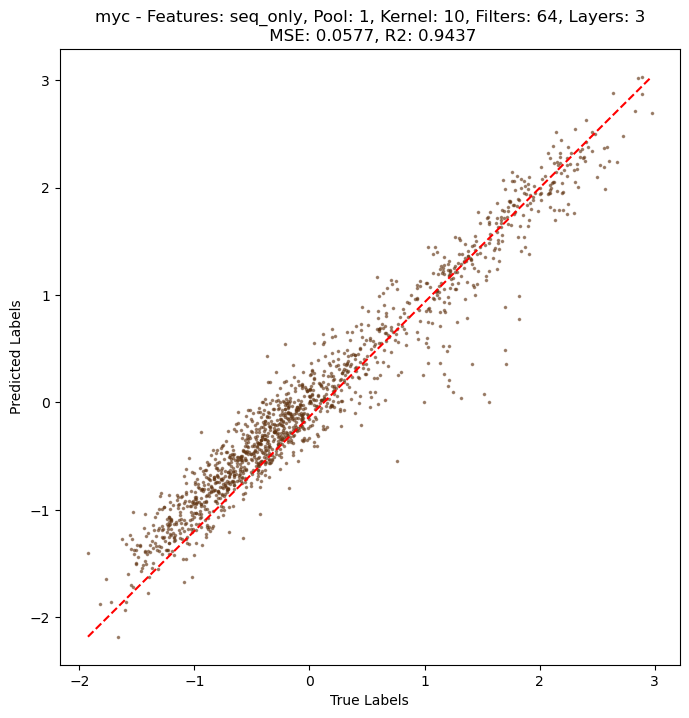

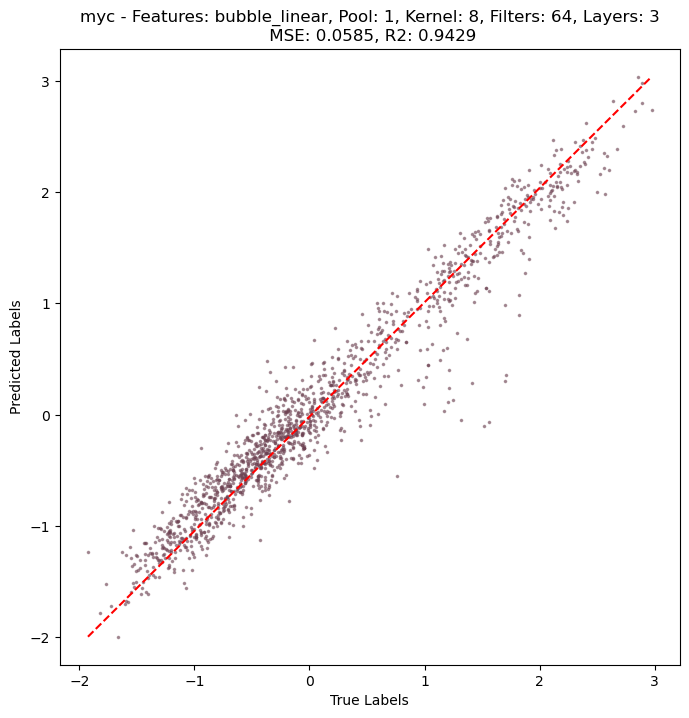

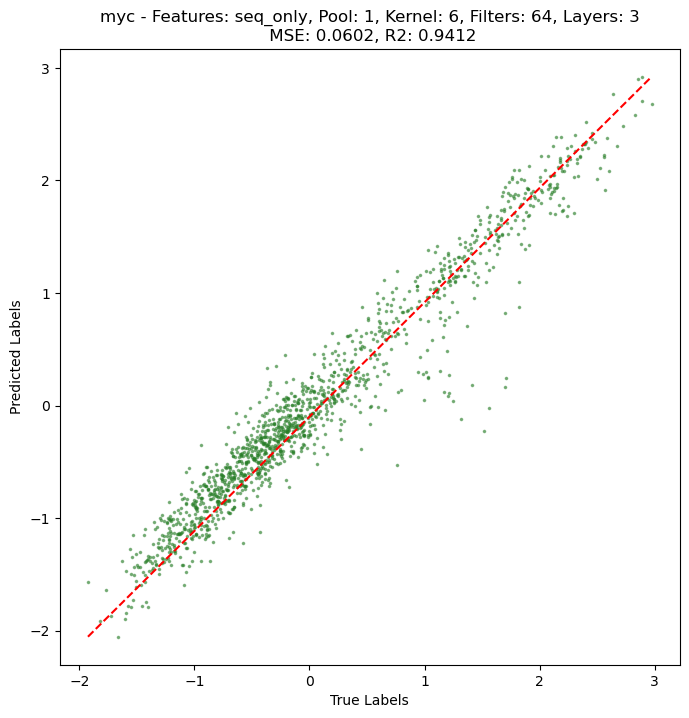

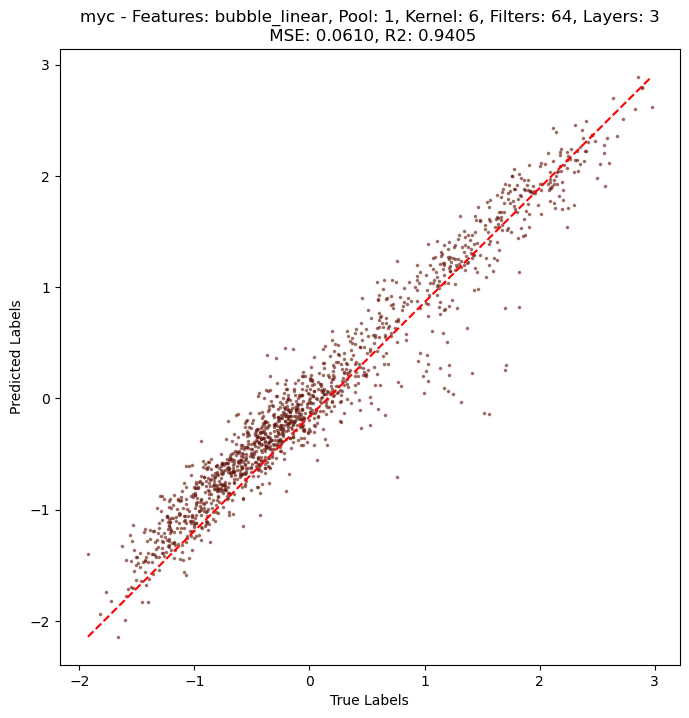

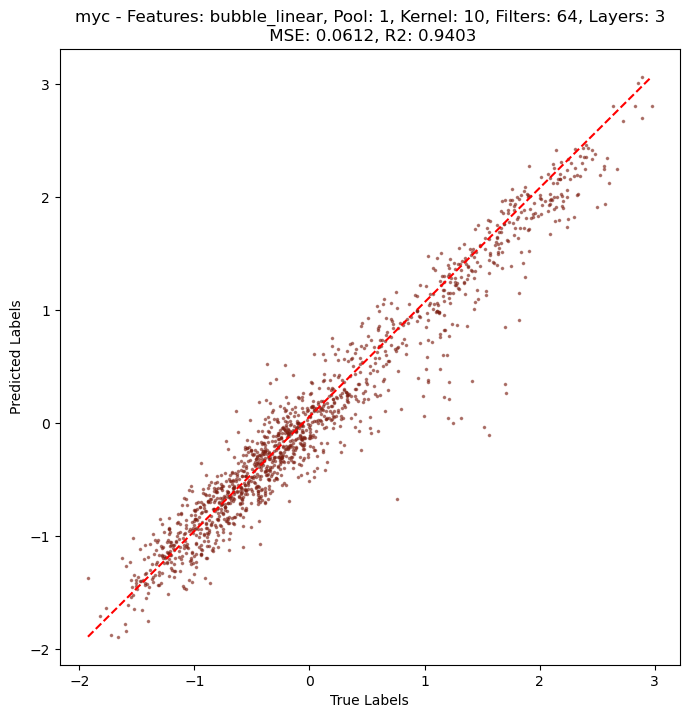

In [35]:
# Iterate over the TF list
for TF in ['mad', 'max', 'myc']:
    # Call the create_true_pred function and assign the results to dynamically generated variable names
    top_mses, top_r2s = accuracy_checker(6, TF)
    
    results[f'{TF}_mses'] = top_mses
    results[f'{TF}_r2s'] = top_r2s
    
    chart_puller(TF)